In [1]:
import os
import numpy as np
import json
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
import random
import cv2
import itertools
from pathlib import Path
from torchvision import transforms
from PIL import Image
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATASET = Path("./Datasets/training")
IMAGES = DATASET / "images"
GROUNDTRUTH = DATASET / "groundtruth"
IMG_FORMAT = ".png"
OUTPUT_DIR = Path("./output")

In [3]:
def get_img_size(img_path):
    """
    returns height and width of img_path
    """
    image = Image.open(img_path)
    width, height = image.size
    return width, height

def groundtruth_to_sem_seg(img_path):
    """
    Transform a binary .jpg image to torch.tensor for sem_seg
    """
    image = Image.open(img_path)
    image = np.array(image).astype(int)
    image[image > 0] = 1
    image = 1 - image
    tensor_mask = torch.from_numpy(image).squeeze_()
    return tensor_mask

In [4]:
def get_data_dicts(img_dir=Path("./Datasets/training")):
    """
    Function to return the json dicts to detectron2
    """
    data_dicts = []
    for img_path in IMAGES.glob("**/*"+IMG_FORMAT):
        filename = img_path
        sem_seg_file_name = GROUNDTRUTH / img_path.name
        width, height = get_img_size(img_path)
        img_id = img_path.name.split("_")[1].split(".")[0]
        sem_seg = groundtruth_to_sem_seg(sem_seg_file_name)
        img_dict = {
            "file_name": str(filename),
            "sem_seg_file_name": str(sem_seg_file_name),
            "sem_seg": sem_seg,
            "height": height,
            "width": width,
            "img_id": img_id,
            "annotations": [],
        }
        data_dicts.append(img_dict)
    return data_dicts      

from detectron2.data import DatasetCatalog, MetadataCatalog

In [5]:
training_dir = Path("./Datasets/training/")
dataset_dicts = get_data_dicts(training_dir)

In [6]:
DatasetCatalog.register("road_training", get_data_dicts)

In [7]:
DatasetCatalog.get('road_training')

[{'file_name': 'Datasets/training/images/satImage_079.png',
  'sem_seg_file_name': 'Datasets/training/groundtruth/satImage_079.png',
  'sem_seg': tensor([[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]),
  'height': 400,
  'width': 400,
  'img_id': '079',
  'annotations': []},
 {'file_name': 'Datasets/training/images/satImage_051.png',
  'sem_seg_file_name': 'Datasets/training/groundtruth/satImage_051.png',
  'sem_seg': tensor([[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]]),
  'height': 400,
  'width': 400,
  'img_id': '051',
  'annotations': []},
 {'file_name': 'Datasets/training/images/satImage_025.png',
  'sem_seg_file_name': 'Datasets/train

In [8]:
MetadataCatalog.get("road_training").set(thing_classes=["road"],
                                        stuff_classes=["roads"])
road_metadata = MetadataCatalog.get("road_training")

{'file_name': 'Datasets/training/images/satImage_097.png', 'sem_seg_file_name': 'Datasets/training/groundtruth/satImage_097.png', 'sem_seg': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 1, 1, 0]]), 'height': 400, 'width': 400, 'img_id': '097', 'annotations': []}
118370
{'file_name': 'Datasets/training/images/satImage_054.png', 'sem_seg_file_name': 'Datasets/training/groundtruth/satImage_054.png', 'sem_seg': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'height': 400, 'width': 400, 'img_id': '054', 'annotations': []}
124797
{'file_name': 'Datasets/training/images/satImage_093.png', 'sem_seg_file_name': 'Datasets/training/groundtruth/satImage_093.png', 'sem_s

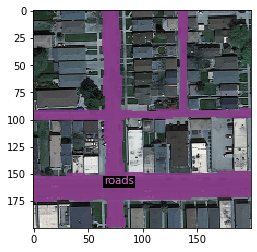

In [9]:
for d in random.sample(dataset_dicts, 3):
    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=road_metadata, 
                            scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    vis = visualizer.draw_sem_seg(sem_seg=d["sem_seg"])
    plt.imshow(vis.get_image()[:, :, ::-1])
    #cv2.imshow(d["img_id"] ,vis.get_image()[:, :, ::-1])
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    print(np.count_nonzero(d["sem_seg"].numpy()))

In [10]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

DETECTRON = Path("/home/tariq/detectron2/")

cfg = get_cfg()
cfg.merge_from_file(str(DETECTRON / "configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("road_training",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
#cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)
cfg.MODEL.DEVICE = "cpu"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

Config '/home/tariq/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


ImportError: libcudart.so.10.1: cannot open shared object file: No such file or directory

In [21]:
road_metadata

Metadata(name='road_training', stuff_classes=['roads'], thing_classes=['road'])